In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


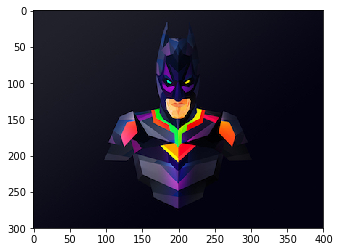

In [4]:
content_image = scipy.misc.imread("images/batman.jpg")
imshow(content_image)

In [5]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list() 
    # Reshape a_C and a_G 
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    J_content = (1/ (4* n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_G_unrolled - a_C_unrolled), 2))
    
    return J_content

In [6]:
tf.reset_default_graph()
with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655935


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


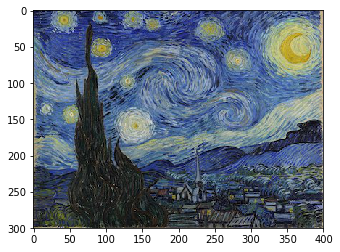

In [7]:
style_image = scipy.misc.imread("images/starrynight.jpg")
imshow(style_image)

In [8]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))    
    return GA

In [9]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


In [10]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) 
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    # Computing the loss 
    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))
    
    return J_style_layer

In [11]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190278


In [12]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [13]:
def compute_style_cost(model, STYLE_LAYERS):
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]
        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)
        a_G = out 
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [14]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

In [15]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [46]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [62]:
content_image = scipy.misc.imread("images/photo.jpg")
content_image = reshape_and_normalize_image(content_image)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [64]:
style_image = scipy.misc.imread("images/starrynight.jpg")
style_image = reshape_and_normalize_image(style_image)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


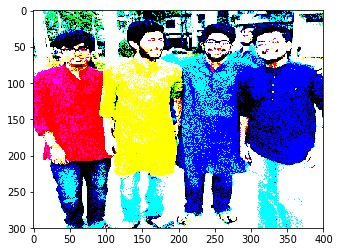

In [65]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [66]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [67]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']
# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)
a_G = out
# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [68]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [69]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [70]:
# define optimizer
optimizer = tf.train.AdamOptimizer(2.0)
# define train_step 
train_step = optimizer.minimize(J)

In [71]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables 
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    for i in range(num_iterations):
        sess.run(train_step)
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])
        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [72]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 3343152400.0
content cost = 15137.914
style cost = 83575020.0
Iteration 20 :
total cost = 272532130.0
content cost = 20542.617
style cost = 6808167.5
Iteration 40 :
total cost = 120301790.0
content cost = 22388.879
style cost = 3001947.5
Iteration 60 :
total cost = 79337016.0
content cost = 23130.754
style cost = 1977642.8
Iteration 80 :
total cost = 60329180.0
content cost = 23716.572
style cost = 1502300.4
Iteration 100 :
total cost = 48808004.0
content cost = 24176.555
style cost = 1214156.0
Iteration 120 :
total cost = 40893316.0
content cost = 24621.004
style cost = 1016177.56
Iteration 140 :
total cost = 35140416.0
content cost = 25039.15
style cost = 872250.6
Iteration 160 :
total cost = 30817054.0
content cost = 25420.143
style cost = 764071.3
Iteration 180 :
total cost = 27458622.0
content cost = 25770.496
style cost = 680022.94


array([[[[ 64.13167   ,  32.97695   ,  28.05739   ],
         [ 30.36759   ,  30.98762   ,  14.472402  ],
         [ 16.39418   ,  21.748775  ,  29.336992  ],
         ...,
         [ 30.072054  ,  27.084835  ,  33.75954   ],
         [ 52.88999   ,  58.817608  , 101.141266  ],
         [ 44.990524  ,  46.88671   ,  20.949368  ]],

        [[ 61.98469   ,  36.09622   ,  29.849386  ],
         [ 40.589775  ,  27.918373  ,  51.7182    ],
         [ 45.23204   ,  60.085674  ,  79.32767   ],
         ...,
         [ 27.399979  ,  16.024902  ,  30.422215  ],
         [ 56.2605    ,  50.366264  ,  64.321075  ],
         [ 53.15418   ,  75.44502   ,  39.518196  ]],

        [[ 39.211735  ,  40.890015  ,  50.753956  ],
         [ 56.13371   ,  45.44556   ,  54.534706  ],
         [ 48.55943   ,  54.233932  ,  66.89616   ],
         ...,
         [ -8.838717  ,  47.251453  ,  40.177124  ],
         [ 49.723686  ,  51.69139   ,  60.957996  ],
         [ 44.066887  ,  64.41017   ,  45.37066   ]],